In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams.update({
    'figure.facecolor': '#121212',
    'figure.figsize': (12, 6),
    'axes.facecolor': '#1e1e1e',
    # 'axes.edgecolor': '#4a90e2',
    'lines.linewidth': 1,
    # 'lines.color': '#4a90e2',
    'text.color': '#cccccc',
    'axes.labelcolor': '#cccccc',
    'xtick.color': '#bbbbbb',
    'ytick.color': '#bbbbbb',
    'axes.titlecolor': '#4a90e2',
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'grid.color': '#333f58',
    'grid.linestyle': '--',
    'grid.linewidth': 0.7,
    'axes.grid': True,
    'legend.facecolor': '#2c2c2c',
    'legend.edgecolor': '#4a90e2',
    'legend.fontsize': 12,
    'legend.fancybox': True,
    'savefig.facecolor': '#121212',
    'savefig.edgecolor': '#121212',
})



In [ ]:
# constants:
A = 0.84
kappa = 1.7e1
H = 12
L = 1.9e4
r = 0.24
# h0 = 0.0025
h0 = 0.00025
omega = 1.4e-4



def perform_numerical_computation(A, kappa, H, L, r, h0, omega, nx):

    dx = 1 / nx
    dt = 0.9 / np.sqrt(kappa) * dx
    nt = int(40 / dt)

    print(dt, dx)


    x_x = np.linspace(-dx, 1 + dx, nx + 2)

    u_xt_ = np.zeros((nx + 2, nt + 1))
    D_xt_ = np.zeros((nx + 2, nt + 1))
    l_t_ = np.zeros(nt + 1)

    D_xt_[0, 0] = 1 + A / H
    D_xt_[:, 0] = (H + A) / H - x_x # since x_x = h_x
    l_t_[0] = 1 # 1.95e4 / 1.9e4



    def update_l(l__t, u_x_t, dt):
        return l__t + u_x_t[-1] * dt

    def update_D(l__t1, l__t2, u_x_t, x_x, D_x_t, dt, dx, t):
        D_x_t2 = np.zeros(nx + 2)
        D_x_t2[0] = A / H * np.cos(t) + 1
        D_x_t2[-1] = 0 # redundant
        D_x_t2[1:-1] = (D_x_t[2:] + D_x_t[:-2]) / 2 + x_x[1:-1] * (l__t2 - l__t1) / l__t1 * (D_x_t[2:] - D_x_t[:-2]) / (2 * dx) - dt / (2 * dx * l__t1) * (D_x_t[2:] * u_x_t[2:] - D_x_t[:-2] * u_x_t[:-2])

        
        return D_x_t2


    def update_u(l__t1, l__t2, u_x_t, x_x, h_x, D_x_t, D_x_t2, dt, dx):
        Lambda = r / (D_x_t2 + h0)


        u_x_t2 = np.zeros(nx + 2)

        u_x_t2[0]    = (u_x_t[0]                     - dt / (2 * dx * l__t1) * (u_x_t[0] *                           (-3*u_x_t[0] + 4 * u_x_t[1] - u_x_t[2])   + kappa * (-3 * D_x_t[0] + 4 * D_x_t[1] - D_x_t[2]   - 3 * h_x[0] + 4 * h_x[1] - h_x[2]))) / (1 + Lambda[0] * dt)

        # u_x_t2[-1]   = (u_x_t[-1]                    - dt / (2 * dx * l__t1) * ((u_x_t[0] - (l__t2 - l__t1) / dt ) * (3*u_x_t[-1] - 4 * u_x_t[-2] + u_x_t[-3]) + kappa * (3 * D_x_t[-1] - 4 * D_x_t[-2] + D_x_t[-3] + 3 * h_x[-1] - 4 * h_x[-2] + h_x[-3]))) / (1 + Lambda[-1] * dt)

        dudx = -(-3 * u_x_t[-1] + 4 * u_x_t[-2] - u_x_t[-3]) / (2*dx)
        dDdx = -(-3 * D_x_t[-1] + 4 * D_x_t[-2] - D_x_t[-3]) / (2*dx)
        dhdx = -(- 3 * h_x[-1] + 4 * h_x[-2] - h_x[-3]) / (2*dx)


        u_x_t2[-1]   = (u_x_t[-1] - dt / l__t1 * (
                (u_x_t[-1] - (l__t2 - l__t1) / dt ) * dudx + kappa * (dDdx + dhdx))
            ) / (1 + Lambda[-1] * dt)

        u_x_t2[1:-1] = ((u_x_t[2:] + u_x_t[:-2]) / 2 + dt / (2 * l__t1 * dx) * ((x_x[1:-1] * (l__t2 - l__t1) / dt - u_x_t[1:-1]) * (u_x_t[2:] - u_x_t[:-2]) - kappa * (D_x_t[2:] - D_x_t[:-2] + h_x[2:] - h_x[:-2]))) / (1 + Lambda[1:-1] * dt)
        
        return u_x_t2


    for timestep in range(nt):
        l_t_[timestep + 1] = update_l(l_t_[timestep], u_xt_[:, timestep], dt)
        D_xt_[:, timestep + 1] = update_D(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, D_xt_[:, timestep], dt, dx, timestep * dt)
        u_xt_[:, timestep + 1] = update_u(l_t_[timestep], l_t_[timestep + 1], u_xt_[:, timestep], x_x, x_x * l_t_[timestep], D_xt_[:, timestep], D_xt_[:, timestep + 1], dt, dx)

    t = np.linspace(0, dt * nt, nt + 1)
    return t, x_x, l_t_, D_xt_, u_xt_




0.002182820625326997 0.01
0.0004365641250653994 0.002
0.0002182820625326997 0.001


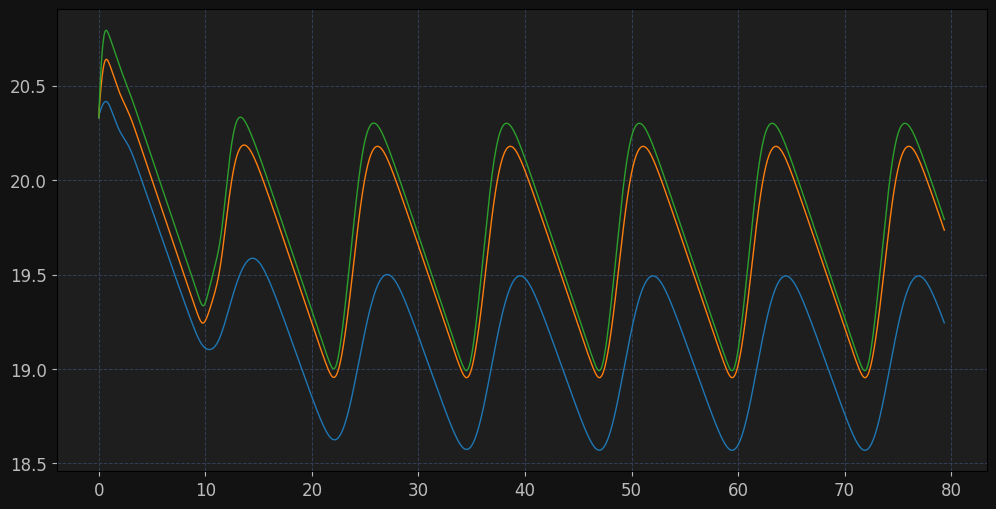

In [3]:
nx = 500

for nx in [100, 500, 1000]:

    t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, L, r, h0, omega, nx)
    #plt.plot(t[len(t)*3//4:] / omega / 3600, l_t_[len(t)*3//4:] * L / 1000)
    plt.plot(t / omega / 3600, l_t_ * L / 1000)




In [4]:
nx = 1000
t, x_x, l_t_, D_xt_, u_xt_ = perform_numerical_computation(A, kappa, H, L, r, h0, omega, nx)


0.0002182820625326997 0.001


[np.int64(107943), np.int64(113700), np.int64(119457), np.int64(125213), np.int64(130970), np.int64(136727)]


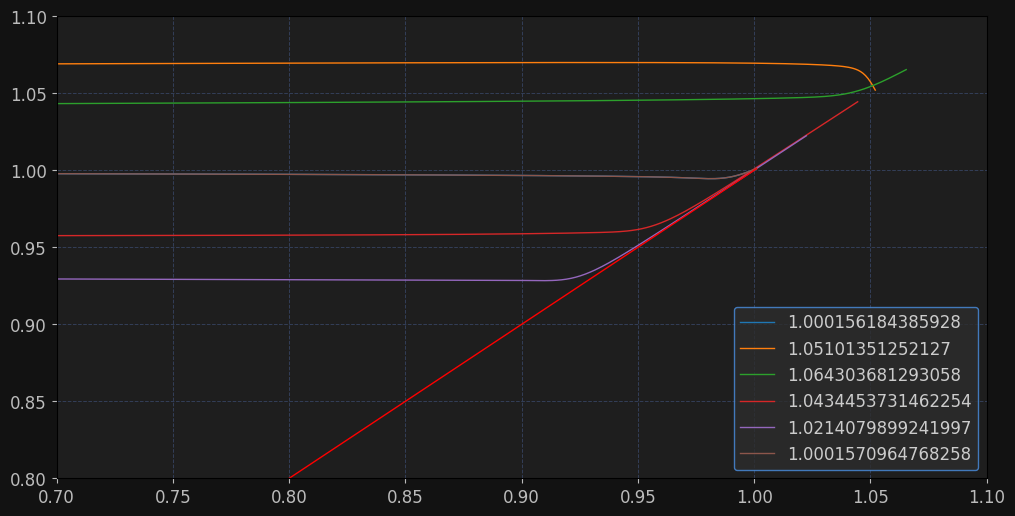

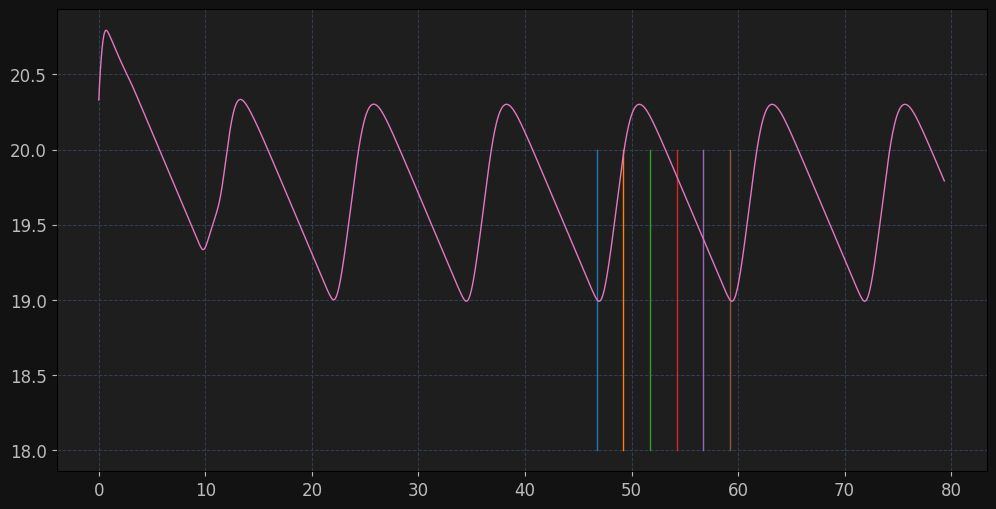

In [5]:

target_times = np.array([1/5, 2/5, 3/5, 4/5, 5/5, 6/5]) + 3.55
target_time_idxs = [np.argmin(np.abs(t - target_time * 2 * np.pi)) for target_time in target_times]
print(target_time_idxs)

for target_time_idx in target_time_idxs:
    # D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx]) /  l_t_[target_time_idx]
    D = (D_xt_[:, target_time_idx] + x_x * l_t_[target_time_idx])# /  l_t_[target_time_idx]


    plt.plot(x_x * l_t_[target_time_idx], D)

plt.plot(x_x, x_x, 'r')
plt.xlim([0.7, 1.1])
plt.ylim([0.8, 1.1])
plt.legend([str(l_t_[target_time_idx]) for target_time_idx in target_time_idxs])



# plt.plot(t[:target_time_idx] / omega / 3600, l_t_[:target_time_idx] * L / 1000)
plt.show()



T = (2*np.pi) / omega


for idx in target_time_idxs:
    plt.plot(np.array([t[idx], t[idx]]) / omega / 3600, [18, 20])



plt.plot(t / omega / 3600, l_t_ * L / 1000)

plt.show()



